## HumanActivityRecognition
This project is to build a model that predicts the human activities such as Walking, Walking_Upstairs, Walking_Downstairs, Sitting, Standing or Laying.



Train and test data were saperated


70% of the Subject's Reading were taken as trianing data and remaining 30% subjects'recordings were taken for test data

### Output Labels
WALKING            -> 1<br>
WALKING UPSTAIRS   -> 2<br>
WALKING DOWNSTAIRS -> 3<br>
SITTING            -> 4<br>
STANDING           -> 5<br>
LYING              -> 6

- 30 volunteers referred to as subjects  performed the experiment for data collection wearing smartphones sensors on their waist.
- The two smartphone sensors captured the 3 axial linear acceleration as well as the 3 axial angular velocity of the subject.
- The sensor signals were sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window).
- The data were recorded at the constant  frequency of 50Hz  (50 data points  were recorded each second ) 
- 561 feature vector were engineered from each time window of 2.56 second with both time and frequency domain variables


### We need to predict the output as one of the 6 labels the user is performing using either handcoded engineered 561 features or raw features of 128 readings

## Distribution of Data
Date points given by 30 subjects(volunteers) is randomly split to 70%(21) train and 30%(9) test data.
Each data-point corresponds one of the 6 Activities.

## Importing all the libraries needed for the LSTM model

In [153]:
import numpy as np       #numpy
import pandas as pd      #pandas
import matplotlib.pyplot as plt   #matplotlib
import seaborn as sns             #seaborn
import tensorflow as tf           #tensorflow
from keras.models import Sequential    #keras
from keras.layers import LSTM          #keras layers
from keras.layers.core import Dense, Dropout  #keras layers core
from keras.layers.normalization import BatchNormalization  #keras layers normalisation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tensorflow import keras

In [154]:
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}


DATADIR = 'UCI_HAR_Dataset'

labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

# Obtaining the train data

In [155]:
X_train = pd.read_csv('UCI_HAR_Dataset/train/X_train.txt', delim_whitespace=True, header=None)


X_train['subject'] = pd.read_csv('UCI_HAR_Dataset/train/subject_train.txt', header=None, squeeze=True)

y_train = pd.read_csv('UCI_HAR_Dataset/train/y_train.txt', names=['Activity'], squeeze=True)
y_train_labels = y_train.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})

train = X_train
train['Activity'] = y_train
train['ActivityName'] = y_train_labels
train.head()

,0,1,2,3,4,5,6,7,8,9,...,554,555,556,557,558,559,560,subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING


In [156]:
print(train.shape,train.size)


(7352, 564) 4146528


# Obtaining the test data

In [157]:

X_test = pd.read_csv('UCI_HAR_Dataset/test/X_test.txt', delim_whitespace=True, header=None)


X_test['subject'] = pd.read_csv('UCI_HAR_Dataset/test/subject_test.txt', header=None, squeeze=True)


y_test = pd.read_csv('UCI_HAR_Dataset/test/y_test.txt', names=['Activity'], squeeze=True)
y_test_labels = y_test.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS', 4:'SITTING', 5:'STANDING',6:'LAYING'})


test = X_test
test['Activity'] = y_test
test['ActivityName'] = y_test_labels
test.head()

,0,1,2,3,4,5,6,7,8,9,...,554,555,556,557,558,559,560,subject,Activity,ActivityName
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,5,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,5,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,5,STANDING


In [158]:
print(test.shape,test.size)

(2947, 564) 1662108


In [159]:
train.to_csv('UCI_HAR_Dataset/csv_files/train.csv', index=False)
test.to_csv('UCI_HAR_Dataset/csv_files/test.csv', index=False)

In [160]:
train = pd.read_csv('UCI_HAR_Dataset/csv_files/train.csv')
test = pd.read_csv('UCI_HAR_Dataset/csv_files/test.csv')
print(train.shape, test.shape)

(7352, 564) (2947, 564)


In [161]:
train.head(1)

,0,1,2,3,4,5,6,7,8,9,...,554,555,556,557,558,559,560,subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.0304,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING


## 1. Visualising the Dataset

In [162]:
sns.set_style('dark')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.family'] = 'DejaVu Sans'

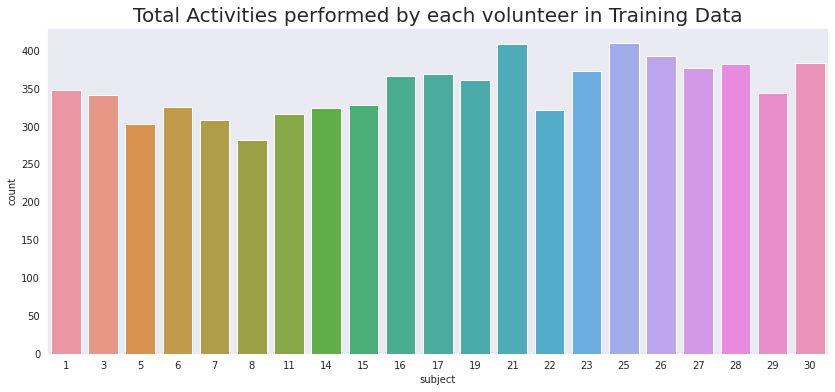

In [163]:
plt.figure(figsize=(14,6))
plt.title("Total Activities performed by each volunteer in Training Data",fontsize=20)
sns.countplot(x=train.subject)
plt.show()

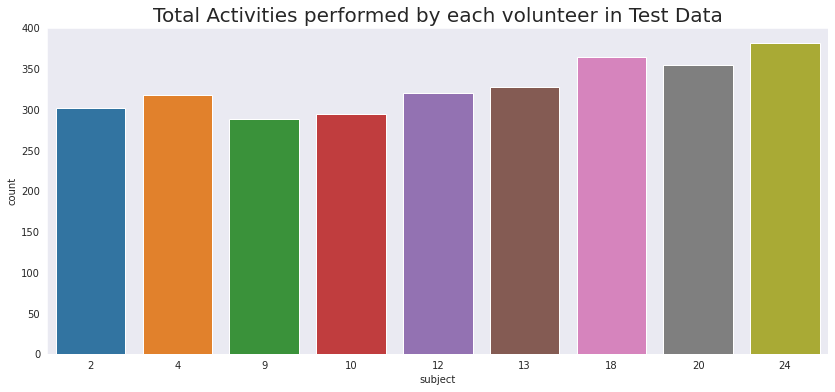

In [164]:
plt.figure(figsize=(14,6))
plt.title("Total Activities performed by each volunteer in Test Data",fontsize=20)
sns.countplot(x=test.subject)
plt.show()

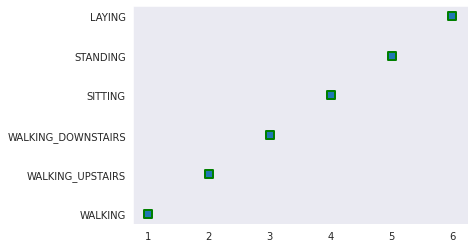

In [165]:
y_train_labels = {1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'}
lists=sorted(y_train_labels.items())
x, y = zip(*lists)
plt.scatter(x, y,linewidths = 2,marker ="s",edgecolor ="green", s = 50)
plt.show()

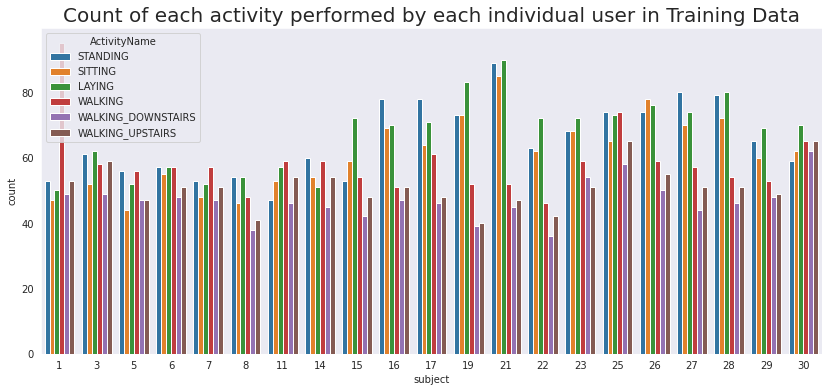

In [166]:
plt.figure(figsize=(14,6))
plt.title('Count of each activity performed by each individual user in Training Data', fontsize=20)
sns.countplot(x='subject',hue='ActivityName', data = train)
plt.show()

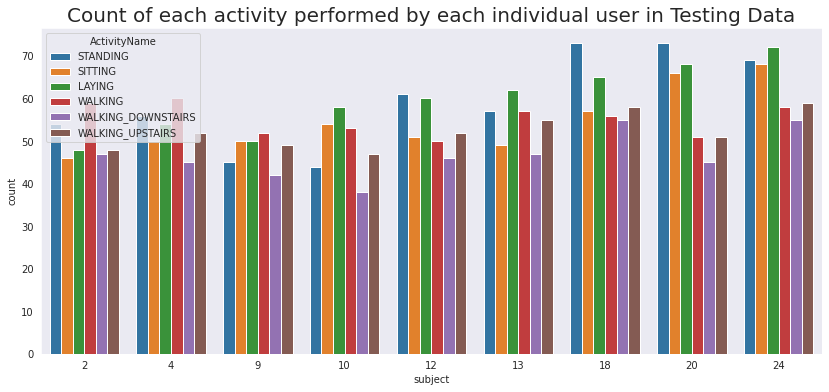

In [167]:
plt.figure(figsize=(14,6))
plt.title('Count of each activity performed by each individual user in Testing Data', fontsize=20)
sns.countplot(x='subject',hue='ActivityName', data = test)
plt.show()

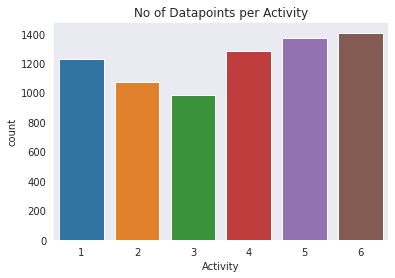

In [168]:
plt.title('No of Datapoints per Activity')
sns.countplot(x=train.Activity)
plt.xticks(rotation=0)
plt.show()

# Data Preprocessing

## 1. Check for Duplicates

In [169]:
print('No of duplicates in train: {}'.format(sum(train.duplicated())))
print('No of duplicates in test : {}'.format(sum(test.duplicated())))

No of duplicates in train: 0
No of duplicates in test : 0


## 2. Checking for NULL values

In [170]:
print('We have {} NaN/Null values in train'.format(train.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(test.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


## LSTM model for HAR

In [171]:
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [172]:
#Configuring a session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)

In [173]:
# Import Keras
from tensorflow.compat.v1.keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [174]:
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [175]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def generate_x_data(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).values) 
    return np.transpose(signals_data, (1, 2, 0))


def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [176]:
def generate_y_data(subset):
    
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).values

In [177]:
X_train, X_test = generate_x_data('train'), generate_x_data('test')
y_train, y_test = generate_y_data('train'), generate_y_data('test')

In [178]:
timesteps = len(X_train[0])
input_dimension = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(len(X_train))
print(timesteps)
print(input_dimension)
print(n_classes)
print(X_train.shape)
print(Y_train.shape)

7352
128
9
6
(7352, 128, 9)
(7352, 6)


In [179]:
epochs = 30
batch_size = 32
n_hidden = 128
pv = 0.25

In [180]:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dimension)))
model.add(BatchNormalization())
model.add(Dropout(pv))          
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               70656     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 774       
Total params: 71,942
Trainable params: 71,686
Non-trainable params: 256
_________________________________________________________________


In [200]:
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])

In [201]:
model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
230/230 [==============================] - 17s 74ms/step - loss: 0.1174 - accuracy: 0.9498 - val_loss: 0.2908 - val_accuracy: 0.9145
Epoch 2/30
230/230 [==============================] - 17s 74ms/step - loss: 0.1407 - accuracy: 0.9497 - val_loss: 0.2972 - val_accuracy: 0.9196
Epoch 3/30
230/230 [==============================] - 17s 74ms/step - loss: 0.1274 - accuracy: 0.9532 - val_loss: 1.1617 - val_accuracy: 0.8470
Epoch 4/30
230/230 [==============================] - 18s 80ms/step - loss: 0.1347 - accuracy: 0.9489 - val_loss: 0.2845 - val_accuracy: 0.9203
Epoch 5/30
230/230 [==============================] - 18s 79ms/step - loss: 0.1055 - accuracy: 0.9521 - val_loss: 0.2868 - val_accuracy: 0.9264
Epoch 6/30
230/230 [==============================] - 18s 77ms/step - loss: 0.1557 - accuracy: 0.9459 - val_loss: 0.4505 - val_accuracy: 0.9179
Epoch 7/30
230/230 [==============================] - 19s 82ms/step - loss: 0.1052 - accuracy: 0.9542 - val_loss: 0.3609 - val_accuracy:

<AxesSubplot:xlabel='Pred', ylabel='True'>

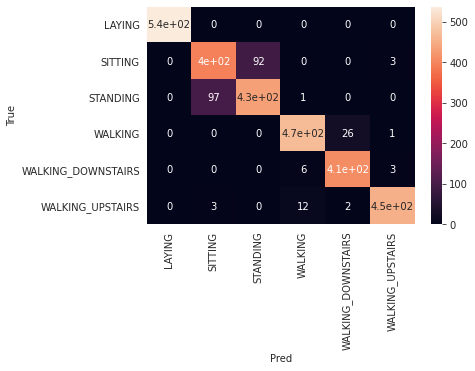

In [202]:
result=confusion_matrix(Y_test, model.predict(X_test))
sn.heatmap(result, annot=True)

In [203]:
score = model.evaluate(X_test, Y_test)

93/93 [==============================] - 2s 18ms/step - loss: 0.3640 - accuracy: 0.9165


In [204]:
score

[0.3639998733997345, 0.9165253043174744]

- With a simple LSTM architecture we got 91.65% accuracy.

### LSTM Model2
<br>
stacking 2 LSTM 

In [186]:
epochs1 = 30
batch_size1= 32
n_hidden1 = 128
n_hidden2 =128
pv1 = 0.2
pv2 = 0.5

In [187]:
model1 = Sequential()

model1.add(LSTM(n_hidden1, return_sequences=True, input_shape=(timesteps, input_dim)))

model1.add(Dropout(pv1))

model1.add(LSTM(n_hidden2))

model1.add(Dropout(pv2))

model1.add(Dense(n_classes, activation='sigmoid'))
model1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128, 128)          70656     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 390       
Total params: 120,454
Trainable params: 120,454
Non-trainable params: 0
_________________________________________________________________


In [188]:
model1.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])

In [194]:
model1.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs1)

Epoch 1/30
230/230 [==============================] - 25s 111ms/step - loss: 0.1481 - accuracy: 0.9491 - val_loss: 0.3288 - val_accuracy: 0.8938
Epoch 2/30
230/230 [==============================] - 27s 117ms/step - loss: 0.1323 - accuracy: 0.9527 - val_loss: 0.3130 - val_accuracy: 0.9060
Epoch 3/30
230/230 [==============================] - 28s 123ms/step - loss: 0.1329 - accuracy: 0.9513 - val_loss: 0.3100 - val_accuracy: 0.9114
Epoch 4/30
230/230 [==============================] - 28s 123ms/step - loss: 0.1240 - accuracy: 0.9508 - val_loss: 0.3442 - val_accuracy: 0.9036
Epoch 5/30
230/230 [==============================] - 28s 123ms/step - loss: 0.1345 - accuracy: 0.9533 - val_loss: 0.3364 - val_accuracy: 0.9016
Epoch 6/30
230/230 [==============================] - 28s 122ms/step - loss: 0.2130 - accuracy: 0.9332 - val_loss: 0.2642 - val_accuracy: 0.9131
Epoch 7/30
230/230 [==============================] - 28s 123ms/step - loss: 0.1355 - accuracy: 0.9429 - val_loss: 0.2765 - val_ac

<AxesSubplot:xlabel='Pred', ylabel='True'>

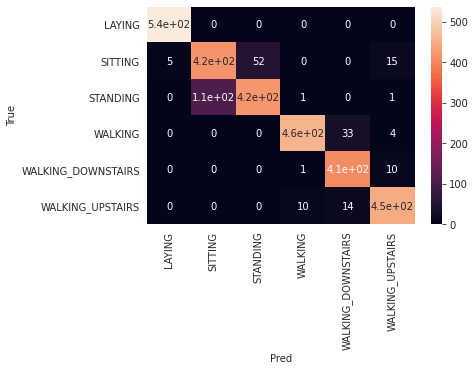

In [195]:
result=confusion_matrix(Y_test, model1.predict(X_test))
sn.heatmap(result, annot=True)

In [196]:
score1 = model1.evaluate(X_test, Y_test)

93/93 [==============================] - 3s 27ms/step - loss: 0.3502 - accuracy: 0.9131


In [205]:
score1

[0.35017648339271545, 0.9131320118904114]

<b>Final Comments</b>
* By Simple two layered LSTM, we got a good accuracy of 91.31%. 
* In short, Deep Learning help us to built models even when we don't have domain expert engineered features. 
* LSTM model can be further improved by running it for more epochs and more evaluations while tuning hyper-parameter.

## Machine learning model(Logistic Regression)

In [208]:
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))
y_test

X_train and y_train : ((7352, 128, 9),(7352, 6))
X_test  and y_test  : ((2947, 128, 9),(2947, 6))


array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [209]:

# get X_train and y_train from csv files
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.Activity
X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.Activity
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))
print(y_train.head())

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))
0    5
1    5
2    5
3    5
4    5
Name: Activity, dtype: int64


In [210]:
print(X_train)

             0         1         2         3         4         5         6  \
0     0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1     0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2     0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3     0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4     0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   
...        ...       ...       ...       ...       ...       ...       ...   
7347  0.299665 -0.057193 -0.181233 -0.195387  0.039905  0.077078 -0.282301   
7348  0.273853 -0.007749 -0.147468 -0.235309  0.004816  0.059280 -0.322552   
7349  0.273387 -0.017011 -0.045022 -0.218218 -0.103822  0.274533 -0.304515   
7350  0.289654 -0.018843 -0.158281 -0.219139 -0.111412  0.268893 -0.310487   
7351  0.351503 -0.012423 -0.203867 -0.269270 -0.087212  0.177404 -0.377404   

             7         8         9  ...       551       552    

In [211]:
print(X_train.sample())

             0         1         2         3         4         5         6  \
4525  0.283203 -0.047024 -0.168986  0.384949  0.176898 -0.310332  0.381757   

             7         8         9  ...       551       552       553  \
4525  0.122611 -0.332984  0.465563  ...  0.454181 -0.730593 -0.932568   

           554       555       556       557      558      559       560  
4525 -0.034924  0.558036  0.258975 -0.854858 -0.78433  0.22296 -0.066506  

[1 rows x 561 columns]


In [212]:
X_train,y_train,X_test,y_test

(             0         1         2         3         4         5         6  \
 0     0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
 1     0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
 2     0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
 3     0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
 4     0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   
 ...        ...       ...       ...       ...       ...       ...       ...   
 7347  0.299665 -0.057193 -0.181233 -0.195387  0.039905  0.077078 -0.282301   
 7348  0.273853 -0.007749 -0.147468 -0.235309  0.004816  0.059280 -0.322552   
 7349  0.273387 -0.017011 -0.045022 -0.218218 -0.103822  0.274533 -0.304515   
 7350  0.289654 -0.018843 -0.158281 -0.219139 -0.111412  0.268893 -0.310487   
 7351  0.351503 -0.012423 -0.203867 -0.269270 -0.087212  0.177404 -0.377404   
 
              7         8         9  ...       551

In [213]:
logistic_regression= LogisticRegression(solver='lbfgs',max_iter=100000)
result=logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

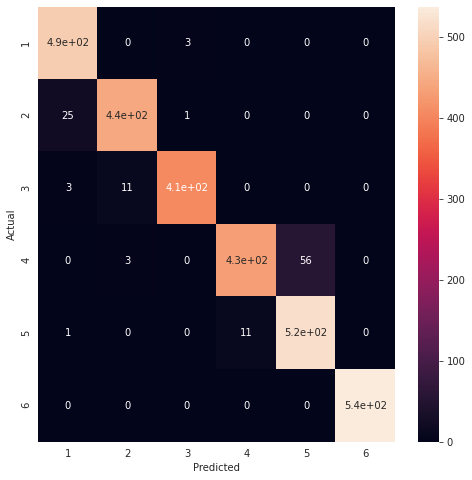

In [214]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

In [215]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Accuracy:  0.9613165931455717
